<a href="https://colab.research.google.com/github/junting-huang/df4a_project/blob/main/regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preprocessing

##0.1 Data Cleaning

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read all dataframes
df_hospital = pd.read_csv('df_hospital_clean.csv')
df_price = pd.read_csv('df_price_clean.csv')
df_pop = pd.read_csv('df_population.csv')
  
# merge all three dataframes
df = pd.merge(df_hospital, df_price, on="hospital_name", how = 'inner')
df = pd.merge(df, df_pop, on="county_name", how = "inner")
  
# correct datatype
df['zip_code'] = df['zip_code'].astype('string')
df['cpt_code'] = df['cpt_code'].astype('string')
df['pcp_ratio'] = df['pcp_ratio'].astype('float')

In [3]:
# select variables
df = df[['cash_price','capacity','revenue','tps_score','pop_density','household_income',
         'unemployment','sex_ratio','children_percent','senior_percent','white_percent',
         'high_school','pcp_ratio','life_exp','uninsured','cpt_code','urban','ownership',
         'type','system','hospital_name']]

# save a copy for dashboard dataframe
df_dash = df

# transforms cpt code to a categorical variable 
service_cat = {'45378':'surgery','59409':'surgery','70450':'high-end test','70551':'high-end test',
               '85025':'low-end test','85027':'low-end test','99203':'visit'}

df['service_cat']= df['cpt_code'].map(service_cat)

# drop n.a. variables
df = df.dropna()
df_copy = df
df = df.drop(['urban','ownership','type','system','hospital_name','service_cat'],axis=1)

In [4]:
# create the new dataframes based on the cpt codes 
df_colon = df.loc[df['cpt_code']== '45378']
df_delivery = df.loc[df['cpt_code'] == '59409']
df_headCT = df.loc[df['cpt_code'] == '70450']
df_brainMRI = df.loc[df['cpt_code'] == '70551']
df_bloodCount = df.loc[df['cpt_code'] == '85025']
df_bloodCountDiff = df.loc[df['cpt_code'] == '85027']
df_visit = df.loc[df['cpt_code'] == '99203']

ls_cpt = [df_colon, df_delivery, df_headCT, df_brainMRI, df_bloodCount, df_bloodCountDiff, df_visit]

## 0.2 Feature Scaling



"Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step." [1]

"Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation." [2]

[1]https://en.wikipedia.org/wiki/Feature_scaling \
[2]https://scikit-learn.org/stable/modules/preprocessing.html

In [5]:
# normalization or standardization in order to scale all procedures to a comparable range 
from sklearn.preprocessing import StandardScaler

scaler_1 = StandardScaler()
df_st = pd.DataFrame()

for i in ls_cpt:
  i = scaler_1.fit_transform(i)
  i = pd.DataFrame(data=i, columns=df.columns)
  df_st = df_st.append(i)

## 0.3 Dummy Variables (Categorical Features)


"Dummy Variables in Regression
In this lesson, we show how to analyze regression equations when one or more independent variables are categorical. The key to the analysis is to express categorical variables as dummy variables.

What is a Dummy Variable?
A dummy variable (aka, an indicator variable) is a numeric variable that represents categorical data, such as gender, race, political affiliation, etc.

Technically, dummy variables are dichotomous, quantitative variables. Their range of values is small; they can take on only two quantitative values. As a practical matter, regression results are easiest to interpret when dummy variables are limited to two specific values, 1 or 0. Typically, 1 represents the presence of a qualitative attribute, and 0 represents the absence." [1]

[1] https://stattrek.com/multiple-regression/dummy-variables.aspx

In [6]:
# reset index for dfs
df_copy['index'] = df_copy.index
df_copy = df_copy.sort_values(by=['cpt_code','index'])

df_copy = df_copy.reset_index()
df = df.reset_index()
df_st = df_st.reset_index()

# create dummy variables
cat_variables = df_copy[['ownership','type','service_cat']]
cat_dummies = pd.get_dummies(cat_variables)

df_cat = pd.concat([df_st, cat_dummies], axis=1)
df_cat = df_cat.drop(['index','cpt_code'],axis=1)
df_cat.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,"ownership_Governmental, County","ownership_Governmental, Other","ownership_Proprietary, Corporation","ownership_Voluntary Nonprofit, Church","ownership_Voluntary Nonprofit, Other",type_Childrens,type_Critical Access,type_Long Term,type_Short Term Acute Care,service_cat_high-end test,service_cat_low-end test,service_cat_surgery,service_cat_visit
0,0.276290,0.883871,0.613576,0.613810,-0.237640,-0.145164,-1.215592,-0.578740,0.492138,-0.875982,-0.238372,1.126136,-0.766368,0.547387,-0.856959,0,0,0,0,1,0,0,0,1,0,0,1,0
1,0.101763,0.690565,0.158453,0.033835,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0,0,0,0,1,0,0,0,1,0,0,1,0
2,-0.267563,0.651904,0.360007,0.268293,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0,0,0,0,1,0,0,0,1,0,0,1,0
3,-0.115894,0.063396,-0.238804,0.231273,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0,0,0,0,1,0,0,0,1,0,0,1,0
4,1.177955,1.519632,0.769618,0.564450,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0,0,0,0,1,0,0,0,1,0,0,1,0


## 0.4 Correlation Matrix

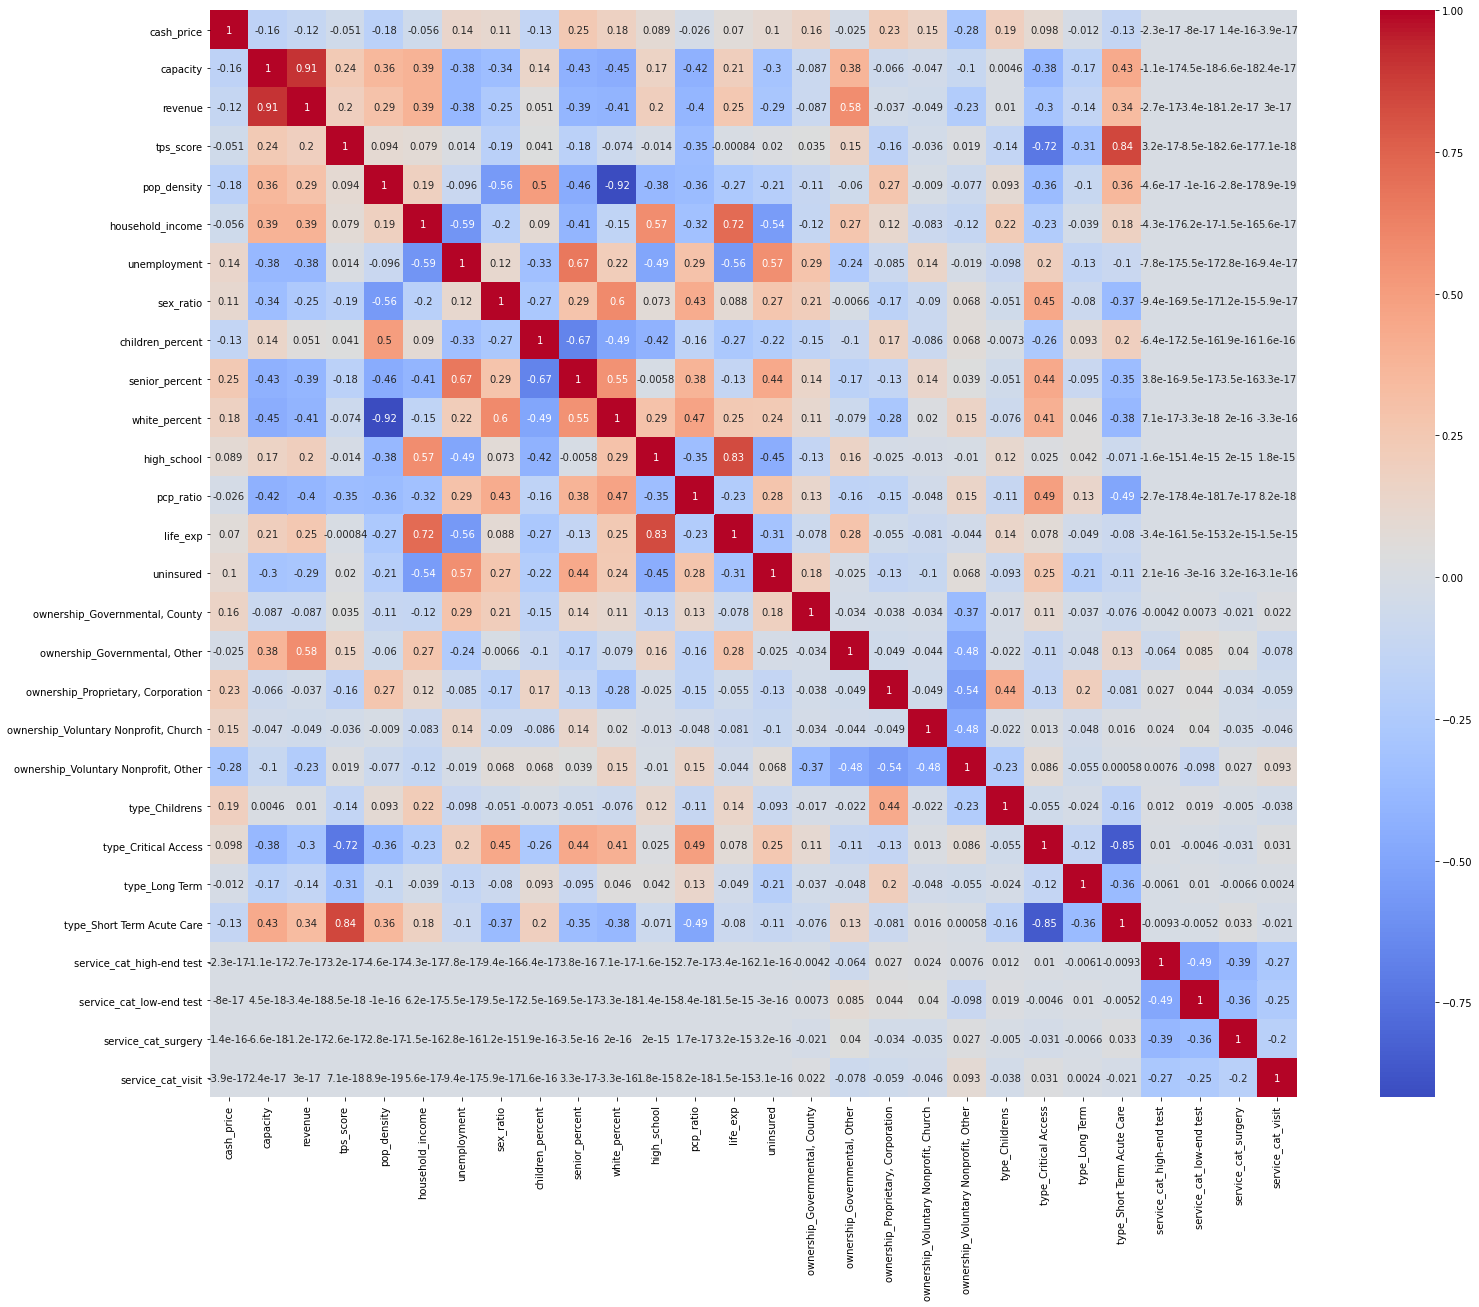

In [ ]:
# Correlation matrix (change the dataframe)
corr_mat=df_cat.corr(method='pearson')
plt.figure(figsize=(30,20))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='coolwarm')

In [ ]:
# pairplot
df_pair = df_st[['cash_price','capacity','pop_density','white_percent','senior_percent','household_income','uninsured','pcp_ratio']]
sns.pairplot(df_pair)

#1. Regression Models


"Model selection and evaluation using tools, such as model_selection.GridSearchCV and model_selection.cross_val_score, take a scoring parameter that controls what metric they apply to the estimators evaluated.

For the most common use cases, you can designate a scorer object with the scoring parameter; the table below shows all possible values. All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric."

[1] https://scikit-learn.org/stable/modules/model_evaluation.html

## 1.1 Preliminary Model Selection


In [7]:
from sklearn import datasets, linear_model
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

In [8]:
# regression model list
regr_list ={'Linear Regression': linear_model.LinearRegression(),
            'Bayesian Regression': linear_model.BayesianRidge(),
            'Least Angle Regression': linear_model.Lars(),
            'Stochastic Gradient Descent': SGDRegressor(),
            'K-Nearest Neighbors': neighbors.KNeighborsRegressor(),
            'Support Vector Machine': svm.SVR(),
            'Decision Tree': tree.DecisionTreeRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Neural Network': MLPRegressor()}

In [9]:
# X is the variables, y is the target (change the variables, or the dataframe below for cpt-code-specific results) 
X = df_cat.drop('cash_price', axis=1)
y = df_cat['cash_price']

# split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for i in regr_list:
  regr = regr_list[i]
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)

  score_1 = r2_score(y_test, y_pred)
  score_2 = mean_absolute_error(y_test, y_pred)
  score_3 = mean_squared_error(y_test, y_pred)

  print(f" {i} \n the r2_score is {score_1},\n the mean_absolute_error is {score_2} ,\n the mean_squared_error is {score_3}." )
  print()

 Linear Regression 
 the r2_score is -0.12901489413334977,
 the mean_absolute_error is 0.7783100757208695 ,
 the mean_squared_error is 1.1709333398477884.

 Bayesian Regression 
 the r2_score is -0.03685762953453642,
 the mean_absolute_error is 0.7310508724854258 ,
 the mean_squared_error is 1.0753544292517876.

 Least Angle Regression 
 the r2_score is -0.15048548759001812,
 the mean_absolute_error is 0.798277385176421 ,
 the mean_squared_error is 1.193201100738604.

 Stochastic Gradient Descent 
 the r2_score is -0.0402351369395344,
 the mean_absolute_error is 0.7276457356463494 ,
 the mean_squared_error is 1.0788573378906774.

 K-Nearest Neighbors 
 the r2_score is 0.012995976136460752,
 the mean_absolute_error is 0.6809554025756063 ,
 the mean_squared_error is 1.0236498420978641.

 Support Vector Machine 
 the r2_score is 0.06804652364356323,
 the mean_absolute_error is 0.6612662245632475 ,
 the mean_squared_error is 0.966555359298838.

 Decision Tree 
 the r2_score is -0.294686771

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.547e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.135e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=6.496e-05, with an active set of 24 regressors, and the smallest cholesky pivot el

 Random Forest 
 the r2_score is 0.17306061024855246,
 the mean_absolute_error is 0.6358851744011004 ,
 the mean_squared_error is 0.8576422742736538.

 Neural Network 
 the r2_score is 0.050393788934495753,
 the mean_absolute_error is 0.6760926894739251 ,
 the mean_squared_error is 0.984863510695018.



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## 1.2 K-Fold Cross-Validation

"Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split." [3]

[1] https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 \
[2]https://scikit-learn.org/stable/modules/cross_validation.html#k-fold \
[3]https://machinelearningmastery.com/k-fold-cross-validation/

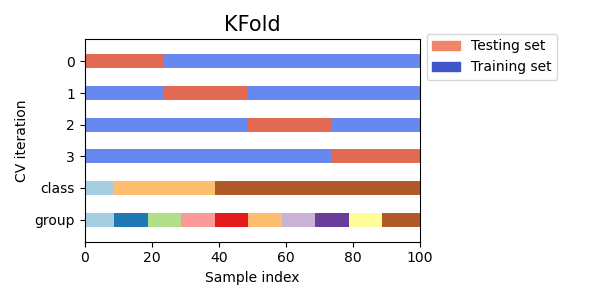

In [ ]:
regr_shortlist ={'Linear Regression': linear_model.LinearRegression(),
            'Support Vector Machine': svm.SVR(),
            'K-Nearest Neighbors': neighbors.KNeighborsRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Neural Network': MLPRegressor()}

def get_r2 (model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return r2_score(y_test, y_pred)

In [ ]:
from sklearn.model_selection import KFold

lr_score = []
br_score = []
knn_score = []
rf_score = []
nn_score = []

# change the number of folds here, 5 or 10 are common
kf = KFold(n_splits=10)
for train, test in kf.split(df_cat):
  X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]

  lr_score.append(get_r2(linear_model.LinearRegression(), X_train, X_test, y_train, y_test))
  br_score.append(get_r2(linear_model.BayesianRidge(), X_train, X_test, y_train, y_test))
  knn_score.append(get_r2(neighbors.KNeighborsRegressor(), X_train, X_test, y_train, y_test))
  rf_score.append(get_r2(RandomForestRegressor(), X_train, X_test, y_train, y_test))
  nn_score.append(get_r2(MLPRegressor(), X_train, X_test, y_train, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# r2 results
lr_av = sum(lr_score)/len(lr_score)
br_av = sum(br_score)/len(br_score)
knn_av = sum(knn_score)/len(knn_score)
rf_av = sum(rf_score)/len(rf_score)
nn_av = sum(nn_score)/len(nn_score)

print('R Squared With K-Fold Cross-Validation')
print(f'Linear Regression Average: {lr_av}')
print(f'Support Vector Machine: {br_av}')
print(f'Nearest Neighbors Average: {knn_av}')
print(f'Random Forest Average: {rf_av}')
print(f'Neural Network Average: {nn_av}')

R Squared With K-Fold Cross-Validation
Linear Regression Average: 0.09529589068581819
Support Vector Machine: 0.11409696053341593
Nearest Neighbors Average: 0.2930074971342309
Random Forest Average: 0.3745201289866415
Neural Network Average: 0.3192206180511179


## 1.3 Model Optimization

Hyperparameter Tuning the Random Forest

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)




**Accuracy Rate = 1 - Absolute Mean Error / (Mean Cash Price - Min Cash Price)**

In [10]:
# Avarage Cash Price - Min Cash Price
y_exp = np.mean(y)
y_min = np.min(y)
y_exp - y_min

1.7206966095412397

### 1.3.1 Randomized Search 

THIS SECTION REQUIRES AT LEAST 20 MIN TO RUN

IT HELPS TO NARROW DOWN THE RANGE OF BEST PARAMETERS, BUT WE ALREADY HAVE THEM SO SKIP TO THE GRID SEARCH IN 1.3.2

"Random Search
Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. It tries random combinations of a range of values. To optimise with random search, the function is evaluated at some number of random configurations in the parameter space. 

The chances of finding the optimal parameter are comparatively higher in random search because of the random search pattern where the model might end up being trained on the optimised parameters without any aliasing. Random search works best for lower dimensional data since the time taken to find the right set is less with less number of iterations. Random search is the best parameter search technique when there are less number of dimensions. In the paper Random Search for Hyper-Parameter Optimization by Bergstra and Bengio, the authors show empirically and theoretically that random search is more efficient for parameter optimization than grid search.
" [1]

[1]https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318


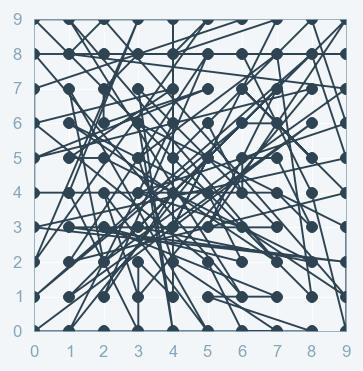

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

In [ ]:
rf_random.best_params_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * (np.mean(abs(errors / 1.7206966095412397)))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * abs(random_accuracy - base_accuracy) / abs(base_accuracy)))

### 1.3.2 Grid Search

"Grid Search
In Grid Search, we try every combination of a preset list of values of the hyper-parameters and evaluate the model for each combination. The pattern followed here is similar to the grid, where all the values are placed in the form of a matrix. Each set of parameters is taken into consideration and the accuracy is noted. Once all the combinations are evaluated, the model with the set of parameters which give the top accuracy is considered to be the best." [1]

[1] https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318


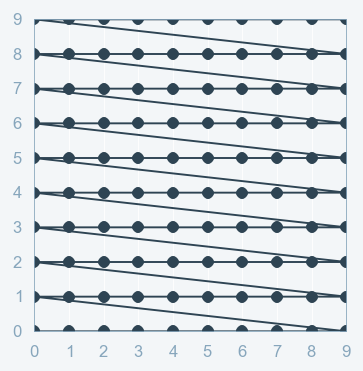

In [12]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [100],
    'max_features': [2],
    'min_samples_leaf': [1],
    'min_samples_split': [3],
    'n_estimators': [1000, 1400]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [13]:
grid_search.fit(X, y)
grid_search.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.3s finished


{'bootstrap': False,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1400}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * (np.mean(abs(errors / 1.7206966095412397)))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * abs(grid_accuracy - base_accuracy) / abs(base_accuracy)))

Model Performance
Average Error: 0.5511 degrees.
Accuracy = 67.97%.

Model Performance
Average Error: 0.0897 degrees.
Accuracy = 94.79%.

Improvement of 39.45%.


In [ ]:
# compare this with other base models
print('Linear Regression')
model_1 = linear_model.LinearRegression()
model_1.fit(X_train, y_train)
evaluate(model_1, X_test, y_test)

print('Support Vector Machine')
model_2 = svm.SVR()
model_2.fit(X_train, y_train)
evaluate(model_2,X_test, y_test)

print('KNN')
model_3 = neighbors.KNeighborsRegressor()
model_3.fit(X_train, y_train)
evaluate(model_3, X_test, y_test)

print('Neural Network')
model_4 = MLPRegressor()
model_4.fit(X_train, y_train)
evaluate(model_4, X_test, y_test)

Linear Regression
Model Performance
Average Error: 0.7076 degrees.
Accuracy = 58.88%.

Support Vector Machine
Model Performance
Average Error: 0.5768 degrees.
Accuracy = 66.48%.

KNN
Model Performance
Average Error: 0.6113 degrees.
Accuracy = 64.47%.

Neural Network
Model Performance
Average Error: 0.5988 degrees.
Accuracy = 65.20%.



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


65.2029092743396

# 2. Prediction

## 2.1 Imputation for the Missing Revenue data

In [15]:
# revenue data missing
df_dash.isna().sum()

cash_price          90
capacity             0
revenue             28
tps_score            0
pop_density          0
household_income     0
unemployment         0
sex_ratio            0
children_percent     0
senior_percent       0
white_percent        0
high_school          0
pcp_ratio            0
life_exp             0
uninsured            0
cpt_code             0
urban                0
ownership            0
type                 0
system               0
hospital_name        0
service_cat          0
dtype: int64

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler_2 = MinMaxScaler()

df_dash_imp = df_dash.drop(['cpt_code','urban','ownership','type','system','hospital_name','service_cat','cash_price'],axis=1)
df_dash_imp = pd.DataFrame(scaler_2.fit_transform(df_dash_imp), columns = df_dash_imp.columns)
df_dash_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   capacity          590 non-null    float64
 1   revenue           562 non-null    float64
 2   tps_score         590 non-null    float64
 3   pop_density       590 non-null    float64
 4   household_income  590 non-null    float64
 5   unemployment      590 non-null    float64
 6   sex_ratio         590 non-null    float64
 7   children_percent  590 non-null    float64
 8   senior_percent    590 non-null    float64
 9   white_percent     590 non-null    float64
 10  high_school       590 non-null    float64
 11  pcp_ratio         590 non-null    float64
 12  life_exp          590 non-null    float64
 13  uninsured         590 non-null    float64
dtypes: float64(14)
memory usage: 64.7 KB


In [17]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_dash_imp = pd.DataFrame(imputer.fit_transform(df_dash_imp),columns = df_dash_imp.columns)
df_dash_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   capacity          590 non-null    float64
 1   revenue           590 non-null    float64
 2   tps_score         590 non-null    float64
 3   pop_density       590 non-null    float64
 4   household_income  590 non-null    float64
 5   unemployment      590 non-null    float64
 6   sex_ratio         590 non-null    float64
 7   children_percent  590 non-null    float64
 8   senior_percent    590 non-null    float64
 9   white_percent     590 non-null    float64
 10  high_school       590 non-null    float64
 11  pcp_ratio         590 non-null    float64
 12  life_exp          590 non-null    float64
 13  uninsured         590 non-null    float64
dtypes: float64(14)
memory usage: 64.7 KB


In [18]:
df_dash_impd = scaler_2.inverse_transform(df_dash_imp)
df_dash_impd = pd.DataFrame(df_dash_impd, columns = df_dash_imp.columns)
df_dash_impd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   capacity          590 non-null    float64
 1   revenue           590 non-null    float64
 2   tps_score         590 non-null    float64
 3   pop_density       590 non-null    float64
 4   household_income  590 non-null    float64
 5   unemployment      590 non-null    float64
 6   sex_ratio         590 non-null    float64
 7   children_percent  590 non-null    float64
 8   senior_percent    590 non-null    float64
 9   white_percent     590 non-null    float64
 10  high_school       590 non-null    float64
 11  pcp_ratio         590 non-null    float64
 12  life_exp          590 non-null    float64
 13  uninsured         590 non-null    float64
dtypes: float64(14)
memory usage: 64.7 KB


In [21]:
df_dash_prep = df_dash.copy()
df_dash_prep['revenue'] = df_dash_impd['revenue'].values
df_dash_prep.head()

,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code,urban,ownership,type,system,hospital_name,service_cat
0,1632.8,356,1.590000e+09,33.0,182.1,56700,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,70450,Urban,"Voluntary Nonprofit, Other",Short Term Acute Care,Ascension Michigan,Ascension_Borgess,high-end test
1,1428.7,356,1.590000e+09,33.0,182.1,56700,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,70551,Urban,"Voluntary Nonprofit, Other",Short Term Acute Care,Ascension Michigan,Ascension_Borgess,high-end test
2,60.0,356,1.590000e+09,33.0,182.1,56700,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,85025,Urban,"Voluntary Nonprofit, Other",Short Term Acute Care,Ascension Michigan,Ascension_Borgess,low-end test
3,3517.8,356,1.590000e+09,33.0,182.1,56700,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,59409,Urban,"Voluntary Nonprofit, Other",Short Term Acute Care,Ascension Michigan,Ascension_Borgess,surgery
4,114.4,356,1.590000e+09,33.0,182.1,56700,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,99203,Urban,"Voluntary Nonprofit, Other",Short Term Acute Care,Ascension Michigan,Ascension_Borgess,visit


## 2.2 DataFrame Preparation

In [25]:
df_dash_prep = df_dash_prep.drop(['urban','ownership','type','system','hospital_name','service_cat'],axis=1)

In [26]:
# create the new dataframes based on the cpt codes 
df_dash_prep_colon = df_dash_prep.loc[df_dash_prep['cpt_code']== '45378']
df_dash_prep_delivery = df_dash_prep.loc[df_dash_prep['cpt_code'] == '59409']
df_dash_prep_headCT = df_dash_prep.loc[df_dash_prep['cpt_code'] == '70450']
df_dash_prep_brainMRI = df_dash_prep.loc[df_dash_prep['cpt_code'] == '70551']
df_dash_prep_bloodCount = df_dash_prep.loc[df_dash_prep['cpt_code'] == '85025']
df_dash_prep_bloodCountDiff = df_dash_prep.loc[df_dash_prep['cpt_code'] == '85027']
df_dash_prep_visit = df_dash_prep.loc[df_dash_prep['cpt_code'] == '99203']

ls_cpt_prep = [df_dash_prep_colon, df_dash_prep_delivery, df_dash_prep_headCT, df_dash_prep_brainMRI, df_dash_prep_bloodCount, df_dash_prep_bloodCountDiff, df_dash_prep_visit]

In [27]:
df_st_prep=pd.DataFrame()

for i in ls_cpt_prep:
  i = scaler_1.fit_transform(i)
  i = pd.DataFrame(data=i, columns=df_dash_prep.columns)
  df_st_prep = df_st_prep.append(i)

df_st_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590 entries, 0 to 61
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cash_price        500 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           590 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
 15  cpt_code          590 non-null    float64
dtypes: float64(16)
memory usage: 78.4 KB


In [31]:
df_dash_copy = df_dash
df_dash_copy['index'] = df_dash_copy.index
df_dash_copy = df_dash_copy.sort_values(by=['cpt_code','index'])

In [32]:
df_dash_copy = df_dash_copy.reset_index()
df_st_prep  = df_st_prep.reset_index()

# create dummy variables
cat_variables = df_dash_copy[['ownership','type','service_cat']]
cat_dummies = pd.get_dummies(cat_variables)

df_cat_prep = pd.concat([df_st_prep, cat_dummies], axis=1)
df_cat_prep = df_cat_prep.drop(['index','cpt_code'],axis=1)
df_cat_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   cash_price                             500 non-null    float64
 1   capacity                               590 non-null    float64
 2   revenue                                590 non-null    float64
 3   tps_score                              590 non-null    float64
 4   pop_density                            590 non-null    float64
 5   household_income                       590 non-null    float64
 6   unemployment                           590 non-null    float64
 7   sex_ratio                              590 non-null    float64
 8   children_percent                       590 non-null    float64
 9   senior_percent                         590 non-null    float64
 10  white_percent                          590 non-null    float64
 11  high_s

In [33]:
df_cat_prep = df_cat_prep.drop('type_Other', axis=1)

## 2.3 Prepare New X for Prediction

In [ ]:
X_new = df_cat_prep.drop('cash_price', axis=1)
y_new = best_grid.predict(X_new)
y_new

In [ ]:
# add prediction to the dataframe
df_dash_final = df_cat_prep
df_dash_final['cash_price_pred'] = y_new
df_dash_final

In [ ]:
# add back cpt code and reverse transform
df_dash.sort_values(by=['cpt_code','index'])['cpt_code']

In [57]:
df_cpt_extract = df_dash.sort_values(by=['cpt_code','index'])['cpt_code']

In [67]:
df_cpt_extract = df_cpt_extract.reset_index()
df_cpt_extract = df_cpt_extract['cpt_code']
df_cpt_extract

0      45378
1      45378
2      45378
3      45378
4      45378
       ...  
585    99203
586    99203
587    99203
588    99203
589    99203
Name: cpt_code, Length: 590, dtype: string

In [ ]:
df_dash_final['cpt_code'] = df_cpt_extract
df_dash_final

In [ ]:
# unify the shape of df_dash_final and df_st_prep

In [ ]:
# replace cash with pred
df_dash_final['cash_price'] = df_dash_final['cash_price_pred']
df_dash_final

In [79]:
to_drop = set(df_dash_final.columns) - set(df_st_prep.columns)

In [83]:
df_dash_final = df_dash_final.drop(columns=to_drop)

In [84]:
df_dash_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cash_price        590 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           590 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
 15  cpt_code          590 non-null    string 
dtypes: float64(15), string(1)
memory usage: 73.9

In [89]:
df_st_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             590 non-null    int64  
 1   cash_price        500 non-null    float64
 2   capacity          590 non-null    float64
 3   revenue           590 non-null    float64
 4   tps_score         590 non-null    float64
 5   pop_density       590 non-null    float64
 6   household_income  590 non-null    float64
 7   unemployment      590 non-null    float64
 8   sex_ratio         590 non-null    float64
 9   children_percent  590 non-null    float64
 10  senior_percent    590 non-null    float64
 11  white_percent     590 non-null    float64
 12  high_school       590 non-null    float64
 13  pcp_ratio         590 non-null    float64
 14  life_exp          590 non-null    float64
 15  uninsured         590 non-null    float64
 16  cpt_code          590 non-null    float64
dt

In [93]:
df_dash_final['cpt_code'] = df['cpt_code'].astype('float')

In [94]:
scaler_1.inverse_transform(df_dash_final.loc[df_dash_final['cpt_code'] == '45378'])

array([], shape=(0, 16), dtype=float64)

In [105]:
# inverse shape 
final_cpt_list = df_dash_final['cpt_code'].unique()

df_inverse_final = pd.DataFrame()

for i in final_cpt_list:
  df_inverse = pd.DataFrame()
  df_inverse = df_dash_final.loc[df_dash_final['cpt_code'] == i]
  df_inverse = scaler_1.inverse_transform(df_inverse)
  df_inverse = pd.DataFrame(data=df_inverse)
  df_inverse_final = df_inverse_final.append(df_inverse)

df_inverse_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3486.069613,427.973320,1.993424e+09,39.098182,173.125037,56489.964169,0.027868,95.763134,0.178912,0.154161,83.078766,0.940125,43.199738,79.117759,0.060248,115828.0
1,594.253744,201.093029,1.104166e+09,32.770292,538.751591,80985.442664,0.030909,96.271048,0.168145,0.173387,76.923425,0.940125,30.450247,80.411876,0.060248,115828.0
2,2430.341027,630.545009,2.371615e+09,32.040151,1069.320252,50615.032335,0.047127,92.918817,0.195925,0.157996,56.601030,0.860595,57.134339,75.534050,0.070393,115828.0
3,543.340211,369.227531,1.047948e+09,27.172543,1069.320252,50615.032335,0.047127,92.918817,0.195925,0.157996,56.601030,0.860595,57.134339,75.534050,0.070393,115828.0
4,520.897856,534.323457,2.944011e+09,30.093107,681.232665,64854.273899,0.040032,94.950472,0.169873,0.174550,82.004024,0.900360,76.650426,78.022736,0.060248,115828.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,3628.969077,43.736749,1.455953e+08,1.979539,470.163168,79328.933167,0.032053,96.735241,0.166860,0.176789,80.134267,0.940101,35.491257,80.224966,0.060433,90756.0
58,3214.627026,40.294816,1.477645e+08,1.979539,957.133336,51142.097393,0.046186,92.869831,0.193763,0.161323,61.412325,0.869437,61.484866,75.893816,0.070384,90756.0
59,2663.434560,39.434333,1.756538e+08,1.979539,-25.322032,47445.463193,0.057669,100.600650,0.138155,0.320097,98.586180,0.913602,69.631144,76.512552,0.080335,90756.0
60,1240.836868,257.997085,9.198348e+08,32.598144,600.936125,64357.564657,0.040003,95.212503,0.168533,0.177957,84.814752,0.904769,80.495952,78.103587,0.060433,90756.0


In [106]:
df_inverse_final.columns = df_dash_final.columns

In [109]:
df_inverse_final.to_csv('df_inverse_final.csv')

In [98]:

set(df_dash_final.columns) - set(df_dash.columns)

set()

In [46]:
set(df_dash.columns) - set(df_dash_final.columns)

{'cpt_code',
 'hospital_name',
 'index',
 'ownership',
 'service_cat',
 'system',
 'type',
 'urban'}

# 3. Plots and Graphs

In [ ]:
import plotly.express as px

In [ ]:
# only run this once before plotting the graph below
df_st = df_st.reset_index()
df_st['urban'] = df_copy['urban']
df_st['ownership'] = df_copy['ownership']
df_st['system'] = df_copy['system']
df_st['type'] = df_copy['type']
df_st['hospital_name'] = df_copy['hospital_name']

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="white_percent", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="white_percent", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="pop_density", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="pop_density", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
sns.lmplot(data=df_st, x="pop_density", y="cash_price", hue='ownership')

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="household_income", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="household_income", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
sns.lmplot(data=df_st, x="household_income", y="cash_price", hue="ownership")

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="senior_percent", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="senior_percent", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="tps_score", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="tps_score", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="pcp_ratio", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="pcp_ratio", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="revenue", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="revenue", y="cash_price",hue='type', size='capacity', sizes=(20, 500))

In [ ]:
# price index for each hospital
df_price_index = df_st.groupby(by='hospital_name')['cash_price'].mean()
df_price_index = pd.DataFrame(df_price_index)
df_price_index = df_price_index.rename(columns={"cash_price":"price_index"})

df_price_index = pd.merge(df_hospital, df_price_index, on="hospital_name", how = 'inner')
df_price_index = pd.merge(df_pop, df_price_index, on="county_name", how = "inner")

df_price_index.to_csv('df_raw.csv')

In [ ]:
df_price_index_new = df_price_index[['hospital_name','price_index','tps_score']]
df_price_index_new.to_csv('df_price_index.csv')

In [ ]:
import plotly.express as px
fig = px.scatter(df_price_index, x="tps_score", y="price_index", color='ownership', hover_data=['hospital_name'])
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter(df_price_index, x="tps_score", y="price_index", color='system', hover_data=['hospital_name'])
fig.show()

In [ ]:
 px.scatter(df_price_index, x="senior_percent", y="price_index", color='ownership', hover_data=['hospital_name'])